# Kriging and Geostatistics

## Geostatistics

**Geostatistics** is a branch of statistics that deals with the analysis, interpretation, and modeling of spatially distributed data. It specifically focuses on understanding and characterizing the variability and spatial dependence of natural phenomena observed at different locations across a geographical area.

Key concepts in geostatistics include:

- **Spatial variability**: Geostatistics investigates how natural phenomena vary across space. This variability can be attributed to both systematic trends (such as gradients or trends) and random fluctuations (such as noise or spatially correlated variation).

```{margin}
This is the first law of geography, as formulated by Tobler.
```
- **Spatial dependence**: Geostatistics recognizes that observations taken at nearby locations tend to be more similar to each other than those taken at distant locations. Understanding and quantifying this spatial dependence is crucial for making predictions and inferences in spatial analysis.

- **Spatial interpolation**: Geostatistics provides methods for estimating the values of a variable at unmeasured locations based on observed data at nearby locations. Techniques like kriging, a commonly used interpolation method in geostatistics, take into account spatial dependence and provide optimal predictions along with uncertainty estimates.

- **Spatial modeling**: Geostatistical models are developed to describe the spatial distribution and variability of a variable of interest. These models incorporate spatial dependence, trend components, and other covariates to provide a comprehensive understanding of the spatial processes under study.

Geostatistics finds applications in various fields such as natural resource exploration (e.g., oil and gas reserves estimation), environmental monitoring (e.g., air and water quality assessment), agriculture (e.g., soil fertility mapping), and urban planning (e.g., land use analysis) and, of course, epidemiology (e.g., disease mapping). It offers powerful tools for spatial data analysis, decision-making, and resource management in both scientific research and practical applications.

In [64]:
import pickle

import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import init_to_median, Predictive, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)  # Set the device count to enable parallel sampling


## Kriging

**Kriging** is a statistical interpolation technique used primarily in geostatistics. It is named after South African mining engineer Daniel G. Krige, who developed the method in the 1950s. Kriging is employed to estimate the value of a variable at an <span style="color:orange">unmeasured location</span> based on the values <span style="color:orange">observed</span> at nearby locations.

The basic idea behind kriging is to model the spatial correlation or spatial autocorrelation of the variable being studied. This means that kriging considers not only the distances between points but also the spatial structure of the data. It assumes that nearby points are more similar than those farther away and uses this information to make predictions.

Kriging provides not only the  <span style="color:orange">predicted value</span> at an unmeasured location but also an estimate of the <span style="color:orange">uncertainty</span> associated with that prediction. This is valuable because it allows users to assess the reliability of the interpolated values.

As you might have guessed, kriging can be performed using Gaussian Processes! GPs are appropriate for kriging due to their flexibility in modeling complex spatial correlations, ability to quantify uncertainty, Bayesian framework for incorporating prior information, flexibility in kernel selection, and handling of interpolation; i.e. GPs tick all the boxes required for kriging.


### Kriging: synthetic visualisation in 2d 

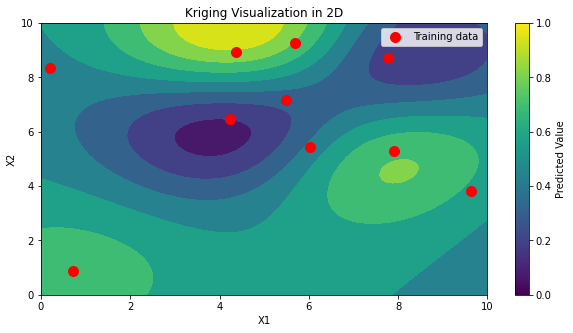

In [2]:
# Generate synthetic data
np.random.seed(0)
x_train = np.random.uniform(0, 10, (10, 2))  # Training points in 2D
y_train = np.sin(x_train[:, 0]) * np.cos(x_train[:, 1])  # Training targets

# Generate grid points for visualization
x_min, x_max = 0, 10
y_min, y_max = 0, 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
x_grid = np.c_[xx.ravel(), yy.ravel()]  # 2D grid points

# Fit Gaussian process model
kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10)
gp.fit(x_train, y_train)

# Predict values for grid points
y_pred, sigma = gp.predict(x_grid, return_std=True)

# Plot the results
plt.figure(figsize=(10, 5))
plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap='viridis')
plt.scatter(x_train[:, 0], x_train[:, 1], color='red', label='Training data', s=100)
# Draw red circles around training points
plt.colorbar(label='Predicted Value')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Kriging Visualization in 2D')
plt.legend()
plt.show()

### 

### Kriging: filling the gaps

In the previous chapter we saw how to infer a true GP curve from noisy data. Note that we had access to observation at all locations.

The task of kriging is different. Here we have observations at some locations, and need to make predictions for other locations.

Let us use the same from the previous chapter.

## 1d example

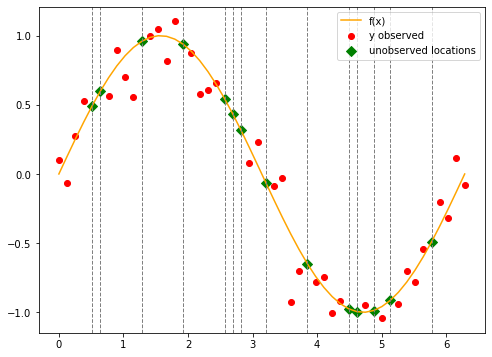

In [50]:
# Generate synthetic data
n_points = 50
x = np.linspace(0, 2*np.pi, n_points)
f_true = np.sin(x)
y_true = f_true + np.random.normal(0, 0.2, size=n_points)

# Define skip_idx
#skip_idx = np.array([4, 5, 10, 14, 15])
skip_idx = np.array([4, 5, 10, 15, 20, 21, 22,  25, 30, 35,36, 38, 40, 45])

# Indices of observed locations excluding skip_idx
obs_idx = np.delete(np.arange(n_points), skip_idx)
y_obs = y_true[obs_idx]

# Plot data
plt.figure(figsize=(8, 6))
plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x[obs_idx], y_obs, color='red', label='y observed')

# Add green crosses at unobserved locations
plt.scatter(x[skip_idx], f_true[skip_idx], color='green', label='unobserved locations', s=50, marker='D')

# Add vertical lines at skip_idx locations
for idx in skip_idx:
    plt.axvline(x=x[idx], color='gray', linestyle='--', linewidth=1)

plt.legend(loc='upper right')
plt.show()


```{margin}
We are being repetitive with the code here. The code is redundant but the aim is for each notebook to be self-sufficient.
```

In [51]:
def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

In [52]:
def model(x, obs_idx, y_obs=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):    

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))

    #sigma = numpyro.sample("sigma", dist.HalfCauchy(1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    
    if y_obs is None:
        numpyro.sample("y", dist.Normal(f[obs_idx], sigma))
    else:   
        numpyro.sample("y", dist.Normal(f[obs_idx], sigma), obs=y_obs)

In [53]:
x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel')
mcmc.run(jax.random.PRNGKey(42), jnp.array(x), jnp.array(obs_idx), jnp.array(y_obs))

Compiling.. :   0%|          | 0/12000 [00:00<?, ?it/s]

Running chain 1: 100%|██████████| 12000/12000 [00:13<00:00, 899.84it/s] 


In [54]:
#mcmc_predictive = Predictive(model, posterior_samples=posterior_samples)
#samples = mcmc_predictive(jax.random.PRNGKey(0), jnp.array(x), jnp.array(obs_idx))
#y_pred = samples["y"]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.06      0.12      0.06     -0.13      0.25   4030.28      1.00
      f[1]      0.15      0.09      0.15     -0.01      0.30   3556.95      1.00
      f[2]      0.25      0.08      0.24      0.12      0.38   3199.10      1.00
      f[3]      0.34      0.08      0.34      0.21      0.47   3024.49      1.00
      f[4]      0.44      0.08      0.44      0.31      0.57   2953.73      1.00
      f[5]      0.53      0.08      0.53      0.40      0.66   2908.24      1.00
      f[6]      0.62      0.08      0.62      0.49      0.76   2884.02      1.00
      f[7]      0.70      0.08      0.70      0.57      0.83   2845.00      1.00
      f[8]      0.77      0.08      0.77      0.65      0.90   2824.03      1.00
      f[9]      0.83      0.07      0.83      0.70      0.94   2820.23      1.00
     f[10]      0.87      0.07      0.87      0.76      0.99   2788.26      1.00
     f[11]      0.90      0

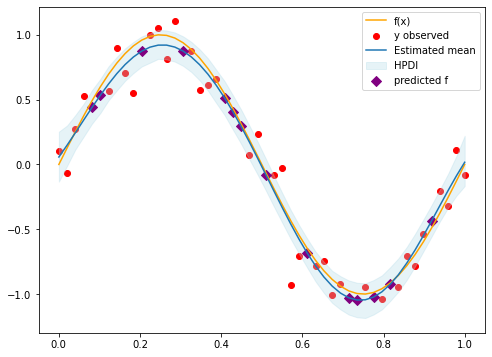

In [55]:
# Print summary statistics of posterior
mcmc.print_summary()

# Get the posterior samples
posterior_samples = mcmc.get_samples()
f_posterior = posterior_samples['f']

# Calculate mean and standard deviation
f_mean = jnp.mean(f_posterior, axis=0)
f_hpdi = hpdi(f_posterior, 0.90)


plt.figure(figsize=(8, 6))
plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x[obs_idx], y_obs, color='red', label='y observed')

# Add green crosses at unobserved locations
#plt.scatter(x[skip_idx], f_true[skip_idx], color='green', label='unobserved locations', s=50, marker='D')
plt.plot(x, f_mean, label='Estimated mean')
plt.fill_between(x.squeeze(), f_hpdi[0], f_hpdi[1], color='lightblue', alpha=0.3, label='HPDI')  # Uncertainty bounds
plt.scatter(x[skip_idx], f_mean[skip_idx], color='purple', label='predicted f', s=50, marker='D')

plt.legend()
plt.show()


Text(0.5, 0, 'Predicte f at unobserved locations')

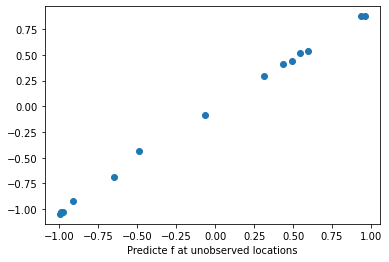

In [58]:
plt.plot(f_true[skip_idx], f_mean[skip_idx], 'o')
plt.xlabel('True f at unobserved locations')
plt.xlabel('Predicte f at unobserved locations')

## 2d example

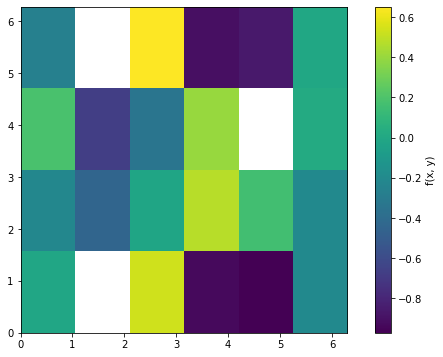

In [86]:
# Generate synthetic data
n_points_x = 6
n_points_y = 4
x = np.linspace(0, 2*np.pi, n_points_x)
y = np.linspace(0, 2*np.pi, n_points_y)
xx, yy = np.meshgrid(x, y)
f_true = np.sin(xx) * np.cos(yy)
noise = np.random.normal(0, 0.2, size=(n_points_y, n_points_x))
f_true += noise

# Define skip_idx
skip_idx = [(0, 1), (2, 4), (3, 1)]

# Plot data with masked values
plt.figure(figsize=(10, 6))
masked_data = np.ma.masked_where(np.zeros_like(f_true, dtype=bool), f_true)

for idx in skip_idx:
    masked_data[idx] = np.ma.masked

plt.imshow(masked_data, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar(label='f(x, y)')

plt.show()


In [93]:
xx.shape

(4, 6)

In [94]:
yy.shape

(4, 6)

In [87]:
obs_idx = [(i, j) for i in range(n_points_x) for j in range(n_points_y) if (i, j) not in skip_idx]

In [88]:
obs_idx

[(0, 0),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 2),
 (3, 3),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3)]

In [ ]:
y_obs

In [89]:

y_obs = f_true[obs_idx]

IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
# Generate synthetic data
n_points = 50
x = np.linspace(0, 2*np.pi, n_points)
f_true = np.sin(x)
y_true = f_true + np.random.normal(0, 0.2, size=n_points)

# Define skip_idx
#skip_idx = np.array([4, 5, 10, 14, 15])
skip_idx = np.array([4, 5, 10, 15, 20, 21, 22,  25, 30, 35,36, 38, 40, 45])

# Indices of observed locations excluding skip_idx
obs_idx = np.delete(np.arange(n_points), skip_idx)
y_obs = y_true[obs_idx]

# Plot data
plt.figure(figsize=(8, 6))
plt.plot(x, f_true, color='orange', label='f(x)')
plt.scatter(x[obs_idx], y_obs, color='red', label='y observed')

# Add green crosses at unobserved locations
plt.scatter(x[skip_idx], f_true[skip_idx], color='green', label='unobserved locations', s=50, marker='D')

# Add vertical lines at skip_idx locations
for idx in skip_idx:
    plt.axvline(x=x[idx], color='gray', linestyle='--', linewidth=1)

plt.legend(loc='upper right')
plt.show()

def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - jitter (float): Small positive value added to the diagonal elements.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

def model(x, obs_idx, y_obs=None, kernel_func=rbf_kernel, lengthcsale=0.2, jitter=1e-5):    

    n = x.shape[0]

    K = kernel_func(x, x, lengthcsale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))

    #sigma = numpyro.sample("sigma", dist.HalfCauchy(1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    
    if y_obs is None:
        numpyro.sample("y", dist.Normal(f[obs_idx], sigma))
    else:   
        numpyro.sample("y", dist.Normal(f[obs_idx], sigma), obs=y_obs)


x = jnp.linspace(0, 1, n_points).reshape(-1, 1)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel')
mcmc.run(jax.random.PRNGKey(42), jnp.array(x), jnp.array(obs_idx), jnp.array(y_obs))

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Generate synthetic data
n_points_x = 6
n_points_y = 4
x = np.linspace(0, 2*np.pi, n_points_x)
y = np.linspace(0, 2*np.pi, n_points_y)
xx, yy = np.meshgrid(x, y)
f_true = np.sin(xx) * np.cos(yy)
noise = np.random.normal(0, 0.2, size=(n_points_y, n_points_x))
f_true += noise

# Define skip_idx
skip_idx = [(0, 0), (1, 0), (3, 0), (4, 0), (0, 1), (1, 1), (2, 1), (4, 1), (0, 2), (2, 2), (3, 2), (0, 3), (1, 3), (3, 3), (4, 3), (5, 3)]
obs_idx = [(i, j) for i in range(n_points_y) for j in range(n_points_x) if (i, j) not in skip_idx]
y_obs = f_true[obs_idx]

# Plot data
plt.figure(figsize=(8, 6))
plt.imshow(f_true, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis')
plt.colorbar(label='f(x, y)')

# Add green crosses at unobserved locations
plt.scatter(xx[np.array(skip_idx)[:,0], np.array(skip_idx)[:,1]], 
            yy[np.array(skip_idx)[:,0], np.array(skip_idx)[:,1]], 
            color='green', label='unobserved locations', s=50, marker='D')

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Synthetic Data')
plt.show()

# Define the RBF kernel for 2D data
def rbf_kernel(x1, x2, lengthscale=1.0, sigma=1.0):
    sq_dist = jnp.sum(x1**2, axis=-1).reshape(-1, 1) + jnp.sum(x2**2, axis=-1) - 2 * jnp.dot(x1, x2.T)
    K = sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)
    return K

# Define the Bayesian model for 2D data
def model(xx, yy, obs_idx, y_obs=None, lengthscale=0.2, jitter=1e-5):
    n = len(obs_idx)
    x = jnp.stack((xx.flatten(), yy.flatten()), axis=-1)
    
    K = rbf_kernel(x, x, lengthscale) + jitter*jnp.eye(n)

    f = numpyro.sample("f", dist.MultivariateNormal(jnp.zeros(n), covariance_matrix=K))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))
    
    if y_obs is None:
        numpyro.sample("y", dist.Normal(f, sigma), obs=y_obs)
    else:
        numpyro.sample("y", dist.Normal(f, sigma))

# Run MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, num_warmup=2000, num_chains=2, chain_method='parallel')
mcmc.run(xx, yy, obs_idx, y_obs)

# Print summary statistics
mcmc.print_summary()

# Plot posterior predictive distribution
posterior_samples = mcmc.get_samples()
for i in range(100):
    y_pred = posterior_samples["f"][i].reshape((n_points_y, n_points_x))
    plt.imshow(y_pred, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='viridis', alpha=0.1)

plt.colorbar(label='f(x, y)')
plt.scatter(xx[obs_idx], yy[obs_idx], color='red', label='y observed')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Posterior Predictive Distribution')
plt.show()


IndexError: index 4 is out of bounds for axis 0 with size 4

## Poisson regression with Gaussian latent random field

## HSGP apprximation

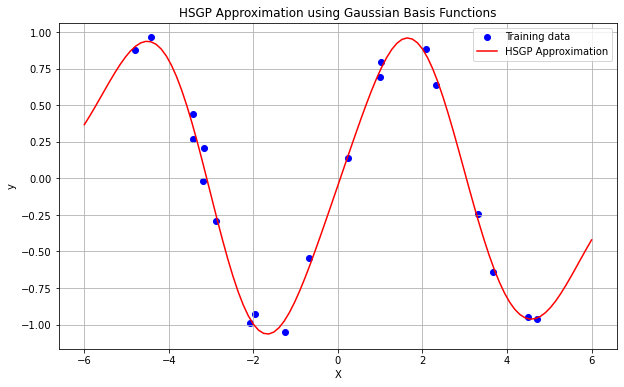

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Define Gaussian basis functions
def gaussian_basis(x, centers, width):
    return np.exp(-0.5 * ((x - centers) / width)**2)

# Generate synthetic data
np.random.seed(42)
X = np.random.uniform(-5, 5, 20)[:, np.newaxis]
y = np.sin(X) + np.random.normal(0, 0.1, size=X.shape)

# Define parameters for Gaussian basis functions
num_basis = 10
centers = np.linspace(-5, 5, num_basis)
width = 1.0

# Compute design matrix
phi = gaussian_basis(X, centers, width)

# Compute coefficients using least squares
alpha = np.linalg.lstsq(phi, y, rcond=None)[0]

# Generate test points
X_test = np.linspace(-6, 6, 100)[:, np.newaxis]

# Compute design matrix for test points
phi_test = gaussian_basis(X_test, centers, width)

# Predict using basis function approximation
y_pred = phi_test.dot(alpha)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Training data')
plt.plot(X_test, y_pred, color='red', label='HSGP Approximation')
plt.xlabel('X')
plt.ylabel('y')
plt.title('HSGP Approximation using Gaussian Basis Functions')
plt.legend()
plt.grid(True)
plt.show()


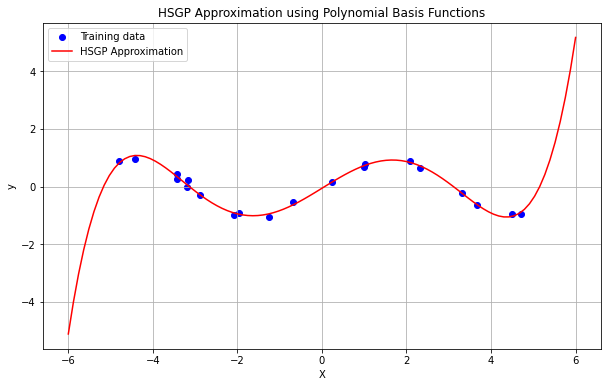

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define polynomial basis functions
def polynomial_basis(x, degree):
    return np.hstack([x**i for i in range(degree + 1)])

# Generate synthetic data
np.random.seed(42)
X = np.random.uniform(-5, 5, 20)[:, np.newaxis]
y = np.sin(X) + np.random.normal(0, 0.1, size=X.shape)

# Define parameters for polynomial basis functions
degree = 5  # Degree of the polynomial
num_basis = degree + 1  # Number of basis functions

# Compute design matrix
phi = polynomial_basis(X, degree)

# Compute coefficients using least squares
alpha = np.linalg.lstsq(phi, y, rcond=None)[0]

# Generate test points
X_test = np.linspace(-6, 6, 100)[:, np.newaxis]

# Compute design matrix for test points
phi_test = polynomial_basis(X_test, degree)

# Predict using basis function approximation
y_pred = phi_test.dot(alpha)

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Training data')
plt.plot(X_test, y_pred, color='red', label='HSGP Approximation')
plt.xlabel('X')
plt.ylabel('y')
plt.title('HSGP Approximation using Polynomial Basis Functions')
plt.legend()
plt.grid(True)
plt.show()
